This project was done by:
Daryl Kow dk3154
Isaac Lim gl2711

## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Dec 21 09:14:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python
from openslide import open_slide, __library_version__ as openslide_version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import tensorflow as tf
import random
import glob
import cv2
import math
import re
import pathlib 
import time

from scipy.ndimage import rotate
from skimage.color import rgb2gray
from matplotlib import cm

### **Building Input Pipeline**
*Data preparation and preprocessing*



In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


### Collecting training data for classifier using the "sliding window" technique over each slide




##### Defining functions to Read Slides, Read Masks and Identify Tissue Pixels

In [ ]:
# Note: x,y coords are with respect to level 0.
# Function to read a region from slide and return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Function to read a region from mask and return a single channel numpy array
def read_mask(slide, x, y, level, width, height, as_float=False):
  im = read_slide(slide, x, y, level, width, height, as_float=False)
  im = im[:,:,0]
  return im

# Function to identify tissue pixels (by filtering out grey areas)
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

##### Defining a function to count the proportion of cancerous and non-cancerous slides

note, slides 99 and 38 were missing parts so they were omitted 

In [ ]:
raw_path = '/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Raw'
slide_indexes = list(set([x[0] for x in [re.findall(r'\d{3}', path) for path in os.listdir(raw_path)][:-1]]))
slide_indexes.sort()
print(slide_indexes)

['001', '002', '005', '012', '016', '019', '023', '031', '035', '057', '059', '064', '075', '078', '081', '084', '091', '094', '096', '101', '110']


In [ ]:
def classify_slides(slide_indexes):
  cancerous = list()
  non_cancerous = list()
  for i in slide_indexes:
    tumor_mask_path = raw_path + f'/tumor_{i}_mask.tif'
    tumor_mask = open_slide(tumor_mask_path)
    thumbnail = tumor_mask.get_thumbnail((128,128))
    thumbnail = np.asarray(thumbnail.convert('RGB'))
    thumbnail = thumbnail[:,:,0]
    if thumbnail.any():
      cancerous.append(i)
    else:
      non_cancerous.append(i)
  return cancerous, non_cancerous 

In [ ]:
cancerous_indexes, non_cancerous_indexes = classify_slides(slide_indexes)

In [ ]:
print(f"No. of cancerous slide indexes: {len(cancerous_indexes)}")
print(f"No. of non-cancerous slide indexes: {len(non_cancerous_indexes)}")

No. of cancerous slide indexes: 13
No. of non-cancerous slide indexes: 8


##### Slide Visualizations:

In [ ]:
image_path = raw_path + f'/tumor_001.tif'
slide1 = open_slide(image_path)

Slide has dimensions: (27648, 12224, 3)


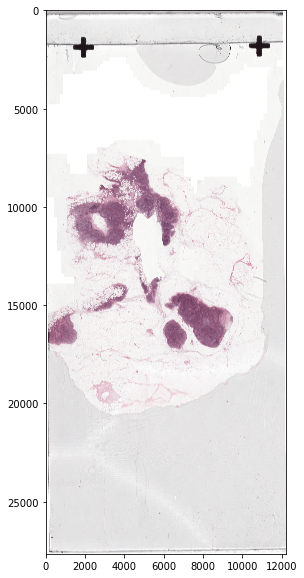

In [ ]:
slide_im = read_slide(slide1, 0, 0, 3, slide1.level_dimensions[3][0], slide1.level_dimensions[3][1])
plt.figure(figsize=(10,10))
print('Slide has dimensions:',slide_im.shape)
plt.imshow(slide_im)

Slide has dimensions: (6912, 3056, 3)


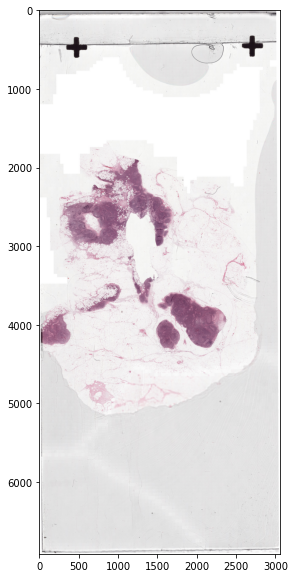

In [ ]:
slide_im = read_slide(slide1, 0, 0, 5, slide1.level_dimensions[5][0], slide1.level_dimensions[5][1])
plt.figure(figsize=(10,10))
print('Slide has dimensions:',slide_im.shape)
plt.imshow(slide_im)

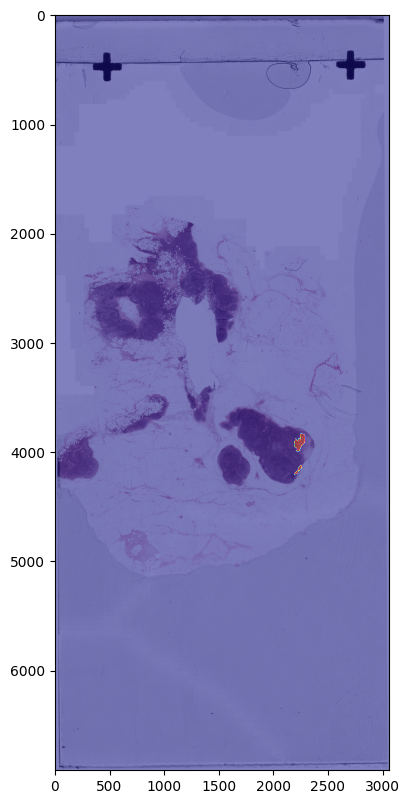

In [ ]:
mask_path = raw_path + f'/tumor_001_mask.tif'
slide_path = raw_path + f'/tumor_001.tif'
slide1 = open_slide(slide_path)
mask1 = open_slide(mask_path)

slide_im = read_slide(slide1, 0, 0, 5, slide1.level_dimensions[5][0], slide1.level_dimensions[5][1])
mask_im = read_mask(mask1, 0, 0, 5, slide1.level_dimensions[5][0], slide1.level_dimensions[5][1])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_im)
plt.imshow(mask_im, cmap='jet', alpha = 0.5)

Unlike a real world situation where we would expect the number of non-cancerous slides at our disposal to be disproportionately greater than the number of cancerous slides, the data we are working with actually affords us more cancerous slides. For the following step where we extract regions from each slide via the sliding window method, we are thus comfortable with using all of the images since the distribution of cancerous and non-cancerous slides does not exacerbate the data imbalance we can later expect between cancerous and non-cancerous regions. We make an effort to ensure that the ratio of cancerous to non-cancerous slides in the train, val and test datasets are roughly balanced. 

Splitting into train, val and test indexes using a 70-15-15 split

In [ ]:
random.seed(123)
random.shuffle(cancerous_indexes)
random.shuffle(non_cancerous_indexes)

train_cancerous_indexes = cancerous_indexes[:round(0.70*len(cancerous_indexes))]
val_cancerous_indexes = cancerous_indexes[round(0.70*len(cancerous_indexes)):round(0.85*len(cancerous_indexes))]
test_cancerous_indexes = cancerous_indexes[round(0.85*len(cancerous_indexes)):]

train_non_cancerous_indexes = non_cancerous_indexes[:round(0.70*len(non_cancerous_indexes))]
val_non_cancerous_indexes = non_cancerous_indexes[round(0.70*len(non_cancerous_indexes)):round(0.85*len(non_cancerous_indexes))]
test_non_cancerous_indexes = non_cancerous_indexes[round(0.85*len(non_cancerous_indexes)):]

In [ ]:
train_indexes = train_cancerous_indexes + train_non_cancerous_indexes
val_indexes = val_cancerous_indexes + val_non_cancerous_indexes
test_indexes = test_cancerous_indexes + test_non_cancerous_indexes

print(f"Train slides: {train_indexes}")
print(f"Validation slides: {val_indexes}")
print(f"Test slides: {test_indexes}")

print(f"No. of train slides: {len(train_indexes)}")
print(f"No. of validation slides: {len(val_indexes)}")
print(f"No. of test slides: {len(test_indexes)}")

Train slides: ['091', '075', '084', '019', '031', '110', '094', '096', '101', '059', '002', '023', '057', '035', '081']
Validation slides: ['078', '016', '005']
Test slides: ['064', '001', '012']
No. of train slides: 15
No. of validation slides: 3
No. of test slides: 3


Sanity check to ensure there are no overlaps in the indices

In [ ]:
if any(index in val_indexes for index in train_indexes) or any(index in test_indexes for index in train_indexes) or any(index in val_indexes for index in test_indexes):
  print("Overlap in indexes, check manual train val test split")

In [ ]:
train_val_test_dict = {'train': train_indexes,
                       'val': val_indexes,
                       'test': test_indexes
}

##### Defining a function to extract patches and labels, split into train, val and test sets and then save to disk

In [ ]:
slides_cleaned_dir = r'/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Cleaned'

In [ ]:
train_val_test_dict

{'test': ['064', '001', '012'],
 'train': ['091',
  '075',
  '084',
  '019',
  '031',
  '110',
  '094',
  '096',
  '101',
  '059',
  '002',
  '023',
  '057',
  '035',
  '081'],
 'val': ['078', '016', '005']}

In [ ]:
# Function to save extracted patch and labels to disk
def extract_patches(levels, patch_shape, raw_path):
  """Note that the list of levels has to be in ascending order, from the most magnified to the least for this function to work."""
  positive_num = 0
  negative_num = 0

  for dataset in train_val_test_dict.keys():
    for level in levels:
      os.makedirs(f'{slides_cleaned_dir}/{dataset}/level{level}/non_cancerous')
      os.mkdir(f'{slides_cleaned_dir}/{dataset}/level{level}/cancerous')
  
  def rotate__flip_positive_slide(image, level_index):
    for i in range(0,4):
      aug_im1 = rotate(image, i*90)
      aug_im2 = np.flip(aug_im1, axis=1)
      assert aug_im1.shape == (patch_shape[0], patch_shape[1], 3)
      assert aug_im2.shape == (patch_shape[0], patch_shape[1], 3)
      aug_path1 = f'{slides_cleaned_dir}/{dataset}/level{levels[level_index]}/cancerous/pos_{(positive_num)+1+i}.jpg'
      aug_path2 = f'{slides_cleaned_dir}/{dataset}/level{levels[level_index]}/cancerous/pos_flip_{(positive_num)+1+i}.jpg'
      cv2.imwrite(aug_path1, aug_im1)
      cv2.imwrite(aug_path2, aug_im2)

  for dataset in train_val_test_dict.keys():
    for i in train_val_test_dict[dataset]:
      slide_path = raw_path + f'/tumor_{i}.tif'
      slide = open_slide(slide_path)
      tumor_mask_path = raw_path + f'/tumor_{i}_mask.tif'
      tumor_mask = open_slide(tumor_mask_path)

      for vert_slide in range(math.ceil(slide.level_dimensions[levels[0]][1]/patch_shape[1])):
        y_coord = int(vert_slide * slide.level_downsamples[levels[0]] * patch_shape[1])

        for horiz_slide in range(math.ceil(slide.level_dimensions[levels[0]][0]/patch_shape[0])):
          x_coord = int(horiz_slide * slide.level_downsamples[levels[0]] * patch_shape[0])
          slide_image = read_slide(slide,
                                  x=x_coord,
                                  y=y_coord,
                                  level=levels[0],
                                  width=patch_shape[0],
                                  height=patch_shape[1])
          
          
          tissue_pixels = find_tissue_pixels(slide_image)

          mask_image = read_mask(tumor_mask,
                                  x=x_coord,
                                  y=y_coord,
                                  level=levels[0],
                                  width=patch_shape[0],
                                  height=patch_shape[1])
        
          mask_tissue_image = np.array([mask_image[pixels] for pixels in tissue_pixels])

          if tissue_pixels:
            if mask_tissue_image.any() == False:
              file_path = f'{slides_cleaned_dir}/{dataset}/level{levels[0]}/non_cancerous/neg_{negative_num+1}.jpg'
              cv2.imwrite(file_path, slide_image)

              for i in range(len(levels)-1):
                slide_image_zoomout = read_slide(slide,
                                                x=x_coord,
                                                y=y_coord,
                                                level=levels[i+1],
                                                width=patch_shape[0],
                                                height=patch_shape[1])
                file_path = f'{slides_cleaned_dir}/{dataset}/level{levels[i+1]}/non_cancerous/neg_{negative_num+1}.jpg' 
                cv2.imwrite(file_path, slide_image_zoomout)

              negative_num += 1

            else:
              file_path = f'{slides_cleaned_dir}/{dataset}/level{levels[0]}/cancerous/pos_{(positive_num)+1}.jpg'
              

              if dataset == 'train':
                rotate__flip_positive_slide(slide_image, 0)
              
              else: 
                cv2.imwrite(file_path, slide_image)

              for i in range(len(levels)-1):
                slide_image_zoomout = read_slide(slide,
                                                x=x_coord,
                                                y=y_coord,
                                                level=levels[i+1],
                                                width=patch_shape[0],
                                                height=patch_shape[1])
                file_path = f'{slides_cleaned_dir}/{dataset}/level{levels[i+1]}/cancerous/pos_{(positive_num)+1}.jpg'
                
                if dataset == 'train':
                  rotate__flip_positive_slide(slide_image_zoomout, 1)
                
                else:
                  cv2.imwrite(file_path, slide_image_zoomout)

              if dataset == 'train':
                positive_num += 8
              else:
                positive_num += 1

  print(f"Number of patches labelled non-cancerous {negative_num}")
  print(f"Number of patches labelled cancerous {positive_num}")
  return positive_num, negative_num

In [ ]:
levels = [4,5]
patch_shape = (224,224)
raw_path = '/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Raw'

##### Applying the function to dataset

In [ ]:
positive_num, negative_num = extract_patches(levels, patch_shape, raw_path)

Number of patches labelled non-cancerous 13433
Number of patches labelled cancerous 2905


Check the number of patches in the directories train, val and test 

In [ ]:
import fnmatch 

for dataset in ['train', 'val', 'test']:
  num_cancer = len(fnmatch.filter(os.listdir(os.path.join(slides_cleaned_dir, dataset, f"level{levels[0]}", "cancerous")), '*.jpg'))
  num_non_cancer = len(fnmatch.filter(os.listdir(os.path.join(slides_cleaned_dir, dataset, f"level{levels[0]}", "non_cancerous")), '*.jpg'))
  print(f'Number of {dataset} cancerous patches: {num_cancer}')
  print(f'Number of {dataset} non-cancerous patches: {num_non_cancer}')
  print(f'Ratio of cancer to non-cancerous patches: {num_cancer/num_non_cancer}')
  print()

Number of train cancerous patches: 2648
Number of train non-cancerous patches: 8921
Ratio of cancer to non-cancerous patches: 0.2968277098979935

Number of val cancerous patches: 209
Number of val non-cancerous patches: 1841
Ratio of cancer to non-cancerous patches: 0.11352525801195003

Number of test cancerous patches: 48
Number of test non-cancerous patches: 2671
Ratio of cancer to non-cancerous patches: 0.017970797454137027



### Create a tf.dataset for training, validation, and testing

In [ ]:
train_dir = pathlib.Path('/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Cleaned/train')
train_3 = tf.data.Dataset.list_files(str(train_dir/f'level{levels[0]}/*/*'), shuffle=False)
train_4 = tf.data.Dataset.list_files(str(train_dir/f'level{levels[1]}/*/*'), shuffle=False)

val_dir = pathlib.Path('/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Cleaned/val')
val_3 = tf.data.Dataset.list_files(str(val_dir/f'level{levels[0]}/*/*'), shuffle=False)
val_4 = tf.data.Dataset.list_files(str(val_dir/f'level{levels[1]}/*/*'), shuffle=False)

test_dir = pathlib.Path('/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Cleaned/test')
test_3 = tf.data.Dataset.list_files(str(test_dir/f'level{levels[0]}/*/*'), shuffle=False)
test_4 = tf.data.Dataset.list_files(str(test_dir/f'level{levels[1]}/*/*'), shuffle=False)

In [ ]:
train_dir_3 = pathlib.Path(f'/content/gdrive/My Drive/COMS4995/Project_Slides_Cleaned/train/level{levels[0]}')
class_names = np.array(sorted([item.name for item in train_dir_3.glob('*')]))
print(class_names)

['cancerous' 'non_cancerous']


In [ ]:
img_width = patch_shape[1]
img_height = patch_shape[0]

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == ['non_cancerous','cancerous' ]
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  img /= 255
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def train_generator():
  for path_3, path_4 in tf.data.Dataset.zip((train_3, train_4)):
    img_3 = decode_img(path_3)
    img_4 = decode_img(path_4)
    label = get_label(path_4)
    yield (img_3, img_4, label)

def val_generator():
  for path_3, path_4 in tf.data.Dataset.zip((val_3, val_4)):
    img_3 = decode_img(path_3)
    img_4 = decode_img(path_4)
    label = get_label(path_3)
    yield (img_3, img_4, label)

def test_generator():
  for path_3, path_4 in tf.data.Dataset.zip((test_3, test_4)):
    img_3 = decode_img(path_3)
    img_4 = decode_img(path_4)
    label = get_label(path_3)
    yield (img_3, img_4, label)

In [ ]:
train_ds = tf.data.Dataset.from_generator(train_generator,
                                          output_signature=(
                                              tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                              tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                              tf.TensorSpec(shape=(), dtype=tf.int32)
                                          ))

val_ds = tf.data.Dataset.from_generator(val_generator,
                                        output_signature=(
                                            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                            tf.TensorSpec(shape=(), dtype=tf.int32)
                                        ))

test_ds = tf.data.Dataset.from_generator(test_generator,
                                         output_signature=(
                                             tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
                                             tf.TensorSpec(shape=(), dtype=tf.float32)
                                          ))

In [ ]:
next(iter(train_ds))[2]

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 1000

In [ ]:
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Sanity check for tf datasets


In [ ]:
train_batch = next(iter(train_ds))
print(train_batch[0].shape)
print(train_batch[1].shape) 
print(train_batch[2].shape) 

(256, 224, 224, 3)
(256, 224, 224, 3)
(256,)


In [ ]:
# Checking if number of cancerous patches corresponds
for dataset in [train_ds, val_ds, test_ds]:
  cancer = 0
  for _, _, label in dataset:
    cancer += np.sum(label.numpy())
  print(f"No. of cancer patches in {dataset}: {cancer}")

No. of cancer patches in <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32, tf.int32)>: 2648
No. of cancer patches in <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32, tf.int32)>: 209
No. of cancer patches in <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 3), (None,)), types: (tf.float32, tf.float32, tf.float32)>: 48.0


In [ ]:
for level4, level5, labels in val_ds.take(1):  # only take first element of dataset
    # image4 = level4.numpy()
    # image5 = level5.numpy()
    labels = labels.numpy()

In [ ]:
labels[:20] #checking our labels are fine.

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
      dtype=int32)

### Defining the multi-zoom model using transfer learning from ResNet50V2

In [ ]:
# Utilities to help us record metrics; we recycle these across the models, so we define them just once. 
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
train_recall = tf.keras.metrics.Mean(name='train_recall')
train_AUC = tf.keras.metrics.Mean(name='train_AUC')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.Accuracy(name='val_accuracy')
val_recall = tf.keras.metrics.Recall(name='val_recall')
val_AUC = tf.keras.metrics.AUC(name='val_AUC')

In [ ]:
def import_resnet():
  model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  return model

members = {}
for i in range(len(levels)):
  members[i+1] = import_resnet()

In [ ]:
def define_stacked_model(members):
  for i in range(len(members)):
    model = members[i+1]
    for layer in model.layers:
      layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

  # define multi input
  stacked_inputs = [model.input for model in members.values()]

  # concatenate output from each model
  stacked_outputs = [model.output for model in members.values()]
  merge = tf.keras.layers.Concatenate()(stacked_outputs)

  # defining the hidden and output layer 
  hidden = tf.keras.layers.GlobalAveragePooling2D()(merge)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
  model = tf.keras.Model(inputs=stacked_inputs, outputs=output)

  return model

In [ ]:
ensemble_model = define_stacked_model(members)

In [ ]:
# plot graph of the ensemble model
tf.keras.utils.plot_model(ensemble_model, show_shapes=True)

In [ ]:
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

##### Creating a checkpoint drive

In [ ]:
checkpoint_dir = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
#checkpoint_dir = os.path.join(checkpoint_dir, "final_project_ensemble_model")
checkpoint_dir = os.path.join(checkpoint_dir, "final_project")

In [ ]:
print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)

Checkpoints directory is /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project
Checkpoints folder already exists


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  ensemble_model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project/cp-00000004.ckpt


In [ ]:
def evaluate(max_steps=None):
  steps = 0
  evaluation_batch = 0
  for image1_batch, image2_batch, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = ensemble_model.predict(x=[image1_batch, image2_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions>0.5)
    val_recall(label_batch, predictions>0.5)
    val_AUC(label_batch, predictions>0.5)
    evaluation_batch += 1
    if evaluation_batch % 5 == 0:
      print(f'{evaluation_batch} validation batches complete')

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history, train_recall_history, train_AUC_history = [], [], [], []
val_loss_history, val_acc_history, val_recall_history, val_AUC_history = [], [], [], []

epochs = 10

# Training loop
for epoch in range(epochs):

  start = time.time()
  train_batch = 0
  class_weights = {0:0.1, 1:0.9}
  # Train for o ne epoch
  for image1_batch, image2_batch, label_batch in train_ds:
    result = ensemble_model.train_on_batch(x=[image1_batch, image2_batch], y=label_batch, class_weight=class_weights)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_recall(result[1])
    train_accuracy(result[2])
    train_AUC(result[3])
    train_batch += 1
    if train_batch % 10 == 0:
      print(f'{train_batch} training batches complete')

  # Evaluate for a few steps
  evaluate()

  # Print progress
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Recall: {:.4f}, AUC: {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}, Val Recall {:.4f}, Val AUC: {:.4f}, Time: {:.4f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        train_recall.result() * 100,
                        train_AUC.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        val_recall.result() * 100,
                        val_AUC.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  train_recall_history.append(train_recall.result() * 100)
  train_AUC_history.append(train_AUC.result())
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)
  val_recall_history.append(val_recall.result() * 100)
  val_AUC_history.append(val_AUC.result())

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  train_AUC.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  val_recall.reset_states()
  val_AUC.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  # Used for formatting
  checkpoint_path = os.path.join(checkpoint_dir, f"cp-{epoch:08d}.ckpt")
  ensemble_model.save_weights(checkpoint_path)

10 training batches complete
5 validation batches complete
Epoch 0, Loss: 0.2832, Accuracy: 53.2744, Recall: 91.9347, AUC: 52.8578, Val Loss 4.0330, Val Accuracy 10.1951, Val Recall 100.0000, Val AUC: 50.0000, Time: 326.8746 secs
Saving weights
10 training batches complete
5 validation batches complete
Epoch 1, Loss: 0.1368, Accuracy: 61.5220, Recall: 100.0000, AUC: 56.3604, Val Loss 2.8418, Val Accuracy 18.9756, Val Recall 100.0000, Val AUC: 54.8886, Time: 251.7491 secs
Saving weights
10 training batches complete
5 validation batches complete
Epoch 2, Loss: 0.0801, Accuracy: 69.7426, Recall: 100.0000, AUC: 60.1877, Val Loss 1.2706, Val Accuracy 51.7561, Val Recall 99.5215, Val AUC: 72.9275, Time: 221.9630 secs
Saving weights
10 training batches complete
5 validation batches complete
Epoch 3, Loss: 0.0681, Accuracy: 79.0959, Recall: 99.8892, AUC: 61.7602, Val Loss 1.3781, Val Accuracy 67.9512, Val Recall 97.1292, Val AUC: 80.8840, Time: 216.9090 secs
Saving weights
10 training batches 

### Testing the multi-zoom ResNet50V2 Model with Equal Class Weights:


In [ ]:
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

In [ ]:
#checkpoint_dir_ensemble_even = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
checkpoint_dir_ensemble_even = os.path.join(checkpoint_dir, "final_project_ensemble_model_even")

In [ ]:
print("Checkpoints directory is", checkpoint_dir_ensemble_even)
if os.path.exists(checkpoint_dir_ensemble_even):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir_ensemble_even)

Checkpoints directory is /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project_ensemble_model/final_project_ensemble_model_even
Creating a checkpoints directory


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir_ensemble_even)
if latest != None:
  print("Loading weights from", latest)
  ensemble_model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history, train_recall_history, train_AUC_history = [], [], [], []
val_loss_history, val_acc_history, val_recall_history, val_AUC_history = [], [], [], []

epochs = 5

# Training loop
for epoch in range(epochs):

  start = time.time()
  train_batch = 0
  class_weights = {0:0.5, 1:0.5}
  # Train for o ne epoch
  for image1_batch, image2_batch, label_batch in train_ds:
    result = ensemble_model.train_on_batch(x=[image1_batch, image2_batch], y=label_batch, class_weight=class_weights)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_recall(result[1])
    train_accuracy(result[2])
    train_AUC(result[3])
    train_batch += 1
    if train_batch % 10 == 0:
      print(f'{train_batch} training batches complete')

  # Evaluate for a few steps
  evaluate()

  # Print progress
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Recall: {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}, Val Recall {:.4f}, Time: {:.4f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        train_recall.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        val_recall.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  train_recall_history.append(train_recall.result() * 100)
  train_AUC_history.append(train_AUC.result())
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)
  val_recall_history.append(val_recall.result() * 100)
  val_AUC_history.append(val_AUC.result())

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  # train_AUC.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  val_recall.reset_states()
  # val_AUC.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  # Used for formatting
  checkpoint_path = os.path.join(checkpoint_dir_ensemble_even, f"cp-{epoch:08d}.ckpt")
  ensemble_model.save_weights(checkpoint_path)

10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 0, Loss: 0.1008, Accuracy: 93.2490, Recall: 49.4084, Val Loss 0.7967, Val Accuracy 89.8049, Val Recall 0.0000, Time: 450.8831 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 1, Loss: 0.6141, Accuracy: 70.2276, Recall: 45.2253, Val Loss 0.2735, Val Accuracy 91.1220, Val Recall 23.4450, Time: 433.5019 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 2, Loss: 0.2284, Accuracy: 84.2117, Recall: 60.7900, Val Loss 0.2872, Val Accuracy 91.1220, Val Recall 19.6172, Time: 402.8434 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batch

### Creating a Toy Multi-Input CNN for Testing:


In [ ]:
def create_CNN():
  input = tf.keras.layers.Input(shape=(224, 224, 3)) 

  conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(input)
  pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(pool1)
  pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

  flat1 = tf.keras.layers.Flatten()(pool2)
  hidden = tf.keras.layers.Dense(64, activation='relu')(flat1)
  dropout = tf.keras.layers.Dropout(0.2)(hidden)

  model = tf.keras.Model(inputs=input, outputs=dropout)
  return model

In [ ]:
model1 = create_CNN()
model2 = create_CNN()

merged = tf.keras.layers.concatenate([model1.output, model2.output])

dense = tf.keras.layers.Dense(64, activation='relu')(merged)

output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

toymodel = tf.keras.Model(inputs=[model1.input, model2.input], outputs=output)

toymodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

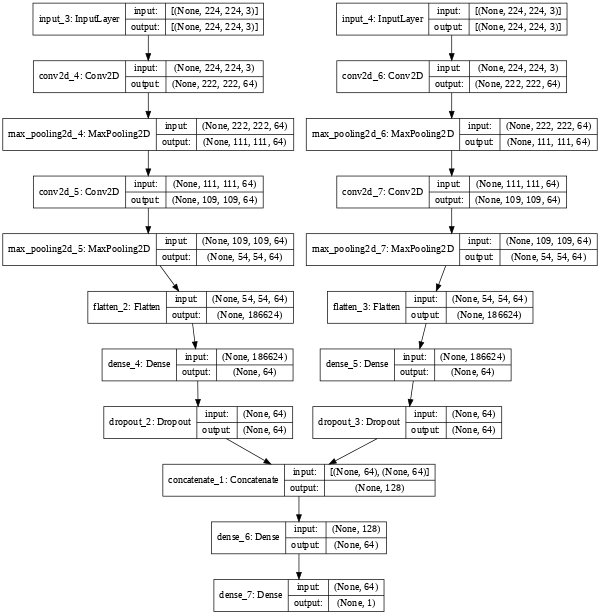

In [ ]:
tf.keras.utils.plot_model(toymodel, show_shapes=True, dpi=50)

##### Creating a checkpoint drive

In [ ]:
checkpoint_dir_toy = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
checkpoint_dir_toy = os.path.join(checkpoint_dir_toy, "final_project_toy_model")

In [ ]:
print("Checkpoints directory is", checkpoint_dir_toy)
if os.path.exists(checkpoint_dir_toy):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir_toy)

Checkpoints directory is /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project_toy_model
Checkpoints folder already exists


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir_toy)
if latest != None:
  print("Loading weights from", latest)
  toymodel.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


In [ ]:
def evaluate_toy(max_steps=None):
  steps = 0
  evaluation_batch = 0
  for image1_batch, image2_batch, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = toymodel.predict_on_batch(x=[image1_batch, image2_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions>0.5)
    val_recall(label_batch, predictions>0.5)
    val_AUC(label_batch, predictions>0.5)
    evaluation_batch += 1
    if evaluation_batch % 5 == 0:
      print(f'{evaluation_batch} validation batches complete')

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history, train_recall_history, train_AUC_history = [], [], [], []
val_loss_history, val_acc_history, val_recall_history, val_AUC_history = [], [], [], []

epochs = 10

# Training loop
for epoch in range(epochs):

  start = time.time()
  train_batch = 0
  # Train for one epoch
  for image1_batch, image2_batch, label_batch in train_ds:
    class_weights = {0:0.1, 1:0.9}
    result = toymodel.train_on_batch(x=[image1_batch, image2_batch], y=label_batch, class_weight=class_weights)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_recall(result[1])
    train_accuracy(result[2])
    train_AUC(result[3])
    train_batch += 1
    if train_batch % 10 == 0:
      print(f'{train_batch} training batches complete')

  # Evaluate for a few steps
  evaluate_toy()

  # Print progress
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Recall: {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}, Val Recall {:.4f}, Time: {:.4f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        train_recall.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        val_recall.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  train_recall_history.append(train_recall.result() * 100)
  train_AUC_history.append(train_AUC.result())
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)
  val_recall_history.append(val_recall.result() * 100)
  val_AUC_history.append(val_AUC.result())

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  train_AUC.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  val_recall.reset_states()
  val_AUC.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  # Used for formatting
  checkpoint_path = os.path.join(checkpoint_dir_toy, f"cp-{epoch:08d}.ckpt")
  toymodel.save_weights(checkpoint_path)

10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 0, Loss: 0.5931, Accuracy: 80.4348, Recall: 39.9972, Val Loss 0.8070, Val Accuracy 89.8049, Val Recall 0.0000, Time: 3985.7650 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 1, Loss: 0.5002, Accuracy: 74.4056, Recall: 27.7316, Val Loss 0.9589, Val Accuracy 89.8049, Val Recall 0.0000, Time: 344.9118 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 2, Loss: 0.5501, Accuracy: 76.5031, Recall: 33.4479, Val Loss 1.2413, Val Accuracy 89.8049, Val Recall 0.0000, Time: 342.4977 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batche

KeyboardInterrupt: ignored

Interrupted the toy-CNN halfway because the validation performance was going nowhere - this was a recurring problem after running the model several times over, suggesting that it was not converging properly. 

### Defining a single magnification ResNet50V2 Model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=inputs)
#base_model.trainable = False

for layer in base_model.layers[:143]:
  layer.trainable= False

single_model = tf.keras.Sequential()
single_model.add(base_model)
single_model.add(tf.keras.layers.Flatten())
single_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

single_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

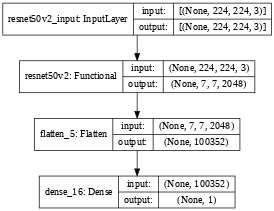

In [ ]:
tf.keras.utils.plot_model(single_model, show_shapes=True, dpi=50)

##### Creating a checkpoint drive

In [ ]:
checkpoint_dir_single = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
checkpoint_dir_single = os.path.join(checkpoint_dir_single, "final_project_single_model")

In [ ]:
print("Checkpoints directory is", checkpoint_dir_single)
if os.path.exists(checkpoint_dir_single):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir_single)

Checkpoints directory is /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project_single_model
Creating a checkpoints directory


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir_single)
if latest != None:
  print("Loading weights from", latest)
  single_model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


In [ ]:
def evaluate_single(max_steps=None):
  steps = 0
  evaluation_batch = 0
  for image1_batch, _, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = single_model.predict(x=image1_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions>0.5)
    val_recall(label_batch, predictions>0.5)
    val_AUC(label_batch, predictions>0.5)
    evaluation_batch += 1
    if evaluation_batch % 5 == 0:
      print(f'{evaluation_batch} validation batches complete')

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history, train_recall_history, train_AUC_history = [], [], [], []
val_loss_history, val_acc_history, val_recall_history, val_AUC_history = [], [], [], []

epochs = 10

# Training loop
for epoch in range(epochs):

  start = time.time()
  train_batch = 0
  class_weights = {0:0.1, 1:0.9}
  # Train for one epoch
  for image1_batch, _, label_batch in train_ds:
    result = single_model.train_on_batch(x=image1_batch, y=label_batch, class_weight=class_weights)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_recall(result[1])
    train_accuracy(result[2])
    train_AUC(result[3])
    train_batch += 1
    if train_batch % 10 == 0:
      print(f'{train_batch} training batches complete')

  # Evaluate for a few steps
  evaluate_single()

  # Print progress
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Recall: {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}, Val Recall {:.4f}, Time: {:.4f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        train_recall.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        val_recall.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  train_recall_history.append(train_recall.result() * 100)
  train_AUC_history.append(train_AUC.result())
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)
  val_recall_history.append(val_recall.result() * 100)
  val_AUC_history.append(val_AUC.result())

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  # train_AUC.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  val_recall.reset_states()
  # val_AUC.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  # Used for formatting
  checkpoint_path = os.path.join(checkpoint_dir_single, f"cp-{epoch:08d}.ckpt")
  ensemble_model.save_weights(checkpoint_path)

10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 0, Loss: 0.1981, Accuracy: 89.3382, Recall: 53.7410, Val Loss 10.4434, Val Accuracy 29.1707, Val Recall 66.5072, Time: 347.7812 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 1, Loss: 0.3644, Accuracy: 45.0359, Recall: 48.6050, Val Loss 1.4307, Val Accuracy 89.5610, Val Recall 0.0000, Time: 325.4355 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batches complete
5 validation batches complete
Epoch 2, Loss: 0.2480, Accuracy: 47.7211, Recall: 53.7398, Val Loss 1.5395, Val Accuracy 88.0000, Val Recall 1.4354, Time: 323.9317 secs
Saving weights
10 training batches complete
20 training batches complete
30 training batches complete
40 training batch

### Code to evaluate on the validation data

In [ ]:
for image1, image2, label in val_ds.take(1):
  val_pred = ensemble_model.predict_on_batch(x=[image1, image2])
  val_label = label

In [ ]:
val_acc_test.reset_states()
val_recall_test.reset_states()

In [ ]:
# val_pred
val_acc_test = tf.keras.metrics.Accuracy(name='val_acc_test')
val_acc_test(val_label , val_pred>0.5)
print(val_acc_test.result())

tf.Tensor(0.8984375, shape=(), dtype=float32)


In [ ]:
val_recall_test = tf.keras.metrics.Recall(name='val_acc_test')
val_recall_test(val_label , val_pred>0.5)
print(val_recall_test.result())

tf.Tensor(0.6530612, shape=(), dtype=float32)


### Defining a fine-tuned ResNet50V2 Model with multizoom

In [ ]:
def import_resnet_tuned():
  model = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet')
  for layer in model.layers[:143]:
    layer.trainable = False
  return model

In [ ]:
def define_stacked_model_tuned(members):
  for i in range(len(members)):
    model = members[i+1]
    for layer in model.layers:
      #layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

  # define multi input
  stacked_inputs = [model.input for model in members.values()]

  # concatenate output from each model
  stacked_outputs = [model.output for model in members.values()]
  merge = tf.keras.layers.Concatenate()(stacked_outputs)

  # defining the hidden and output layer 
  hidden = tf.keras.layers.GlobalAveragePooling2D()(merge)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
  model = tf.keras.Model(inputs=stacked_inputs, outputs=output)

  return model

In [ ]:
members = {}
for i in range(len(levels)):
  members[i+1] = import_resnet_tuned()

ensemble_model_tuned = define_stacked_model_tuned(members)

In [ ]:
for i, layer in enumerate(ensemble_model_tuned.layers):
    print(layer.trainable) #make sure the model is indeed tunable in later layers

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [ ]:
ensemble_model_tuned.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.AUC()])

##### Creating a checkpoint drive

In [ ]:
checkpoint_dir_ensemble_tuned = os.path.join('/content/gdrive/MyDrive/COMS4995_Project', 'checkpoints')
checkpoint_dir_ensemble_tuned = os.path.join(checkpoint_dir_ensemble_tuned, "final_project_ensemble_model_tuned")

In [ ]:
print("Checkpoints directory is", checkpoint_dir_ensemble_tuned)
if os.path.exists(checkpoint_dir_ensemble_tuned):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir_ensemble_tuned)

Checkpoints directory is /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project_ensemble_model_tuned
Checkpoints folder already exists


In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir_ensemble_tuned)
if latest != None:
  print("Loading weights from", latest)
  ensemble_model_tuned.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/gdrive/MyDrive/COMS4995_Project/checkpoints/final_project_ensemble_model_tuned/cp-00000009.ckpt


In [ ]:
def evaluate_tuned(max_steps=None):
  steps = 0
  evaluation_batch = 0
  for image1_batch, image2_batch, label_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = ensemble_model_tuned.predict(x=[image1_batch, image2_batch])
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions>0.5)
    val_recall(label_batch, predictions>0.5)
    val_AUC(label_batch, predictions>0.5)
    evaluation_batch += 1
    if evaluation_batch % 5 == 0:
      print(f'{evaluation_batch} validation batches complete')

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history, train_recall_history, train_AUC_history = [], [], [], []
val_loss_history, val_acc_history, val_recall_history, val_AUC_history = [], [], [], []

epochs = 10

# Training loop
for epoch in range(epochs):

  start = time.time()
  train_batch = 0
  class_weights = {0:0.1, 1:0.9}
  # Train for o ne epoch
  for image1_batch, image2_batch, label_batch in train_ds:
    result = ensemble_model_tuned.train_on_batch(x=[image1_batch, image2_batch], y=label_batch, class_weight=class_weights)
    
    # Record metrics after each batch
    train_loss(result[0])
    train_recall(result[1])
    train_accuracy(result[2])
    train_AUC(result[3])
    train_batch += 1
    if train_batch % 10 == 0:
      print(f'{train_batch} training batches complete')

  # Evaluate for a few steps
  evaluate_tuned()

  # Print progress
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Recall: {:.4f}, AUC: {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}, Val Recall {:.4f}, Val AUC {:.4f},  Time: {:.4f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        train_recall.result() * 100,
                        train_AUC.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        val_recall.result() * 100,
                        val_AUC.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  train_recall_history.append(train_recall.result() * 100)
  train_AUC_history.append(train_AUC.result())
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)
  val_recall_history.append(val_recall.result() * 100)
  val_AUC_history.append(val_AUC.result())

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  train_AUC.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
  val_recall.reset_states()
  val_AUC.reset_states()

  # Save a checkpoint after each epoch
  print("Saving weights")
  # Used for formatting
  checkpoint_path = os.path.join(checkpoint_dir_ensemble_tuned, f"cp-{epoch:08d}.ckpt")
  ensemble_model_tuned.save_weights(checkpoint_path)

10 training batches complete
5 validation batches complete
Epoch 0, Loss: 0.0298, Accuracy: 90.0671, Recall: 99.8329, AUC: 64.3902, Val Loss 0.8690, Val Accuracy 66.7805, Val Recall 86.1244, Val AUC 75.3544,  Time: 245.7083 secs
Saving weights
10 training batches complete
5 validation batches complete
Epoch 1, Loss: 0.0260, Accuracy: 93.8494, Recall: 99.6346, AUC: 64.4130, Val Loss 1.7675, Val Accuracy 70.3415, Val Recall 88.0383, Val AUC 78.1853,  Time: 250.1036 secs
Saving weights
10 training batches complete
5 validation batches complete
Epoch 2, Loss: 0.0234, Accuracy: 95.2955, Recall: 99.7728, AUC: 64.5791, Val Loss 0.7043, Val Accuracy 78.0488, Val Recall 71.7703, Val AUC 75.2659,  Time: 237.5471 secs
Saving weights
10 training batches complete
5 validation batches complete
Epoch 3, Loss: 0.0206, Accuracy: 97.1456, Recall: 99.9608, AUC: 64.6245, Val Loss 0.5698, Val Accuracy 84.2927, Val Recall 37.7990, Val AUC 63.6850,  Time: 251.4185 secs
Saving weights
10 training batches comp

### Base Multi-zoom ResNet Model Heatmap

In [ ]:
test_indexes 
#['064', '001', '012']
#We test our predictions with slide 064 first

['064', '001', '012']

In [ ]:
raw_path = '/content/gdrive/MyDrive/COMS4995_Project/Project_Slides_Raw'
slide = '064'
levels = [4,5]
patch_shape = (224,224)

In [ ]:
slide_path = raw_path + f'/tumor_{slide}.tif'
tumor_mask_path = raw_path + f'/tumor_{slide}_mask.tif'

test_slide = open_slide(slide_path)
test_mask = open_slide(tumor_mask_path)

In [ ]:
test_image = read_slide(test_slide,
                                x=0,
                                y=0,
                                level=levels[0],
                                width=test_slide.level_dimensions[levels[0]][0],
                                height=test_slide.level_dimensions[levels[0]][1])

tumor_image = read_mask(test_mask,
                                x=0,
                                y=0,
                                level=levels[0],
                                width=test_mask.level_dimensions[levels[0]][0],
                                height=test_mask.level_dimensions[levels[0]][1])


In [ ]:
#we have to use this resized plot to plot our heatmaps because having too large an image with too much range in its 
def resized_plot(slide_image, basewidth=1000): 
  from PIL import Image
  
  arr = np.copy(slide_image)
  img = Image.fromarray(arr)
  wpercent = (basewidth/float(img.size[0]))
  hsize = int((float(img.size[1])*float(wpercent)))
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)
  a = np.asarray(img)
  return a

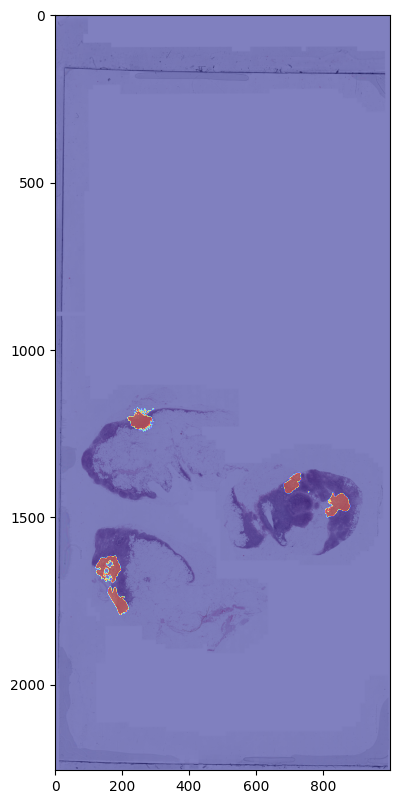

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_plot(test_image))
plt.imshow(resized_plot(tumor_image), cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
patches_dict = {}
for level in levels:
  patches_dict['level' + str(level)] = []
patches_dict['labels'] = []

In [ ]:
for vert_slide in range(math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])):
  y_coord = int(vert_slide * test_slide.level_downsamples[levels[0]] * patch_shape[1])

  for horiz_slide in range(math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[0])):
    x_coord = int(horiz_slide * test_slide.level_downsamples[levels[0]] * patch_shape[0])
    
    level_name = 'level' + str(levels[0])

    slide_image = read_slide(test_slide,
                                x=x_coord,
                                y=y_coord,
                                level=levels[0],
                                width=patch_shape[0],
                                height=patch_shape[1])

    patches_dict[level_name].append(slide_image)

    
    mask_image = read_mask(test_mask,
                                  x=x_coord,
                                  y=y_coord,
                                  level=levels[0],
                                  width=patch_shape[0],
                                  height=patch_shape[1])
    
    tissue_pixels = find_tissue_pixels(slide_image)
    mask_tissue_image = np.array([mask_image[pixels] for pixels in tissue_pixels])
    
    if mask_tissue_image.any() == False:
      patches_dict['labels'].append(0)
    else:
      patches_dict['labels'].append(1)
    
    for i in range(len(levels)-1):
          level_name = 'level' + str(levels[i+1])
          slide_image_zoomout = read_slide(test_slide,
                                            x=x_coord,
                                            y=y_coord,
                                            level=levels[i+1],
                                            width=patch_shape[0],
                                            height=patch_shape[1])
          
          patches_dict[level_name].append(slide_image_zoomout)

In [ ]:
sum(patches_dict['labels'])

39

In [ ]:
#just to make sure we have the same number
for key, value in patches_dict.items():
  length = len(value)
  print(f'{key}: Length {length}')

level4: Length 1736
level5: Length 1736
labels: Length 1736


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((np.array(patches_dict['level4'])/255,np.array(patches_dict['level5'])/255))

In [ ]:
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
predictions = []
for x1,x2 in dataset:
    predictions.extend(ensemble_model.predict_on_batch(x=[x1,x2]).tolist())

In [ ]:
vert_patches = math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])
hor_patches = math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[1])

In [ ]:
predictions = np.array(predictions)
predictions.resize(vert_patches,hor_patches)

In [ ]:
test_heatmap = np.copy(tumor_image)
test_heatmap = test_heatmap.astype('float')

for j in range(math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[0])):
  for i in range(math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])):
    y = i*patch_shape[0]
    x = j*patch_shape[1]
    width = patch_shape[0]
    height = patch_shape[1]
    test_heatmap[y:y+height,x:x+width] = predictions[i,j]

In [ ]:
assert test_heatmap.shape == test_image[:,:,0].shape

In [ ]:
test_heatmap_filtered = np.copy(test_heatmap)
zero_filter = test_heatmap < 0.6
test_heatmap_filtered[zero_filter] = 0

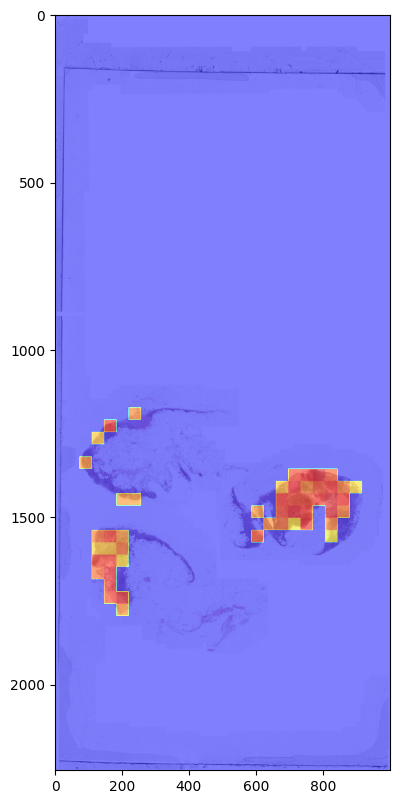

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_plot(test_image))
plt.imshow(resized_plot(test_heatmap_filtered), cmap='jet', alpha=0.5) # Red regions contains cancer.

### Tuned ResNet Heatmap

In [ ]:
predictions = []
for x1,x2 in dataset:
    predictions.extend(ensemble_model_tuned.predict_on_batch(x=[x1,x2]).tolist())

In [ ]:
vert_patches = math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])
hor_patches = math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[1])

In [ ]:
predictions = np.array(predictions)
predictions.resize(vert_patches,hor_patches)

In [ ]:
test_heatmap = np.copy(tumor_image)
test_heatmap = test_heatmap.astype('float')

for j in range(math.ceil(test_slide.level_dimensions[levels[0]][0]/patch_shape[0])):
  for i in range(math.ceil(test_slide.level_dimensions[levels[0]][1]/patch_shape[1])):
    y = i*patch_shape[0]
    x = j*patch_shape[1]
    width = patch_shape[0]
    height = patch_shape[1]
    test_heatmap[y:y+height,x:x+width] = predictions[i,j]

In [ ]:
assert test_heatmap.shape == test_image[:,:,0].shape

In [ ]:
test_heatmap_filtered = np.copy(test_heatmap)
zero_filter = test_heatmap < 0.6
test_heatmap_filtered[zero_filter] = 0

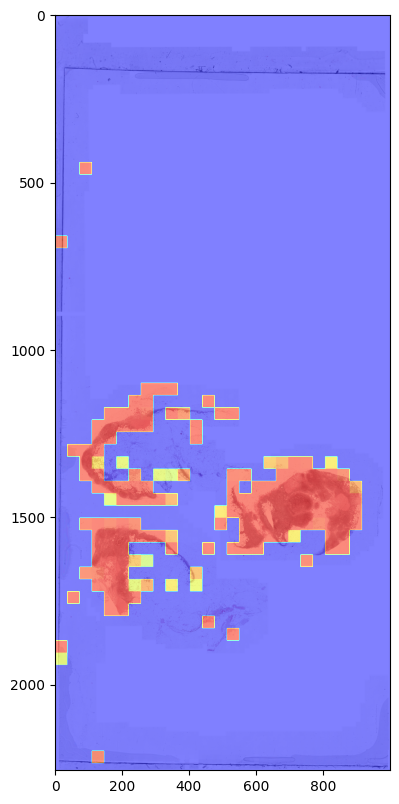

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(resized_plot(test_image))
plt.imshow(resized_plot(test_heatmap_filtered), cmap='jet', alpha=0.5) # Red regions contains cancer.

### Calculating Test Metrics and Conclusion

In [ ]:
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
test_recall = tf.keras.metrics.Recall(name='test_recall')
test_AUC = tf.keras.metrics.AUC(name='test_AUC')

In [ ]:
def evaluate_test(max_steps=None):
  steps = 0
  test_batch = 0
  for image1_batch, image2_batch, label_batch in test_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = ensemble_model_tuned.predict(x=[image1_batch, image2_batch])
    steps += 1 
    # Record metrics after each batch
    test_loss(label_batch, predictions)
    test_accuracy(label_batch, predictions>0.6)
    test_recall(label_batch, predictions>0.6)
    test_AUC(label_batch, predictions>0.6)
    test_batch += 1
    if test_batch % 5 == 0:
      print(f'{test_batch} test batches complete')

def evaluate_test_base(max_steps=None):
  steps = 0
  test_batch = 0
  for image1_batch, image2_batch, label_batch in test_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = ensemble_model.predict(x=[image1_batch, image2_batch])
    steps += 1 
    # Record metrics after each batch
    test_loss(label_batch, predictions)
    test_accuracy(label_batch, predictions>0.6)
    test_recall(label_batch, predictions>0.6)
    test_AUC(label_batch, predictions>0.6)
    test_batch += 1
    if test_batch % 5 == 0:
      print(f'{test_batch} test batches complete')

def evaluate_test_toy(max_steps=None):
  steps = 0
  test_batch = 0
  for image1_batch, image2_batch, label_batch in test_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = toymodel.predict(x=[image1_batch, image2_batch])
    steps += 1 
    # Record metrics after each batch
    test_loss(label_batch, predictions)
    test_accuracy(label_batch, predictions>0.6)
    test_recall(label_batch, predictions>0.6)
    test_AUC(label_batch, predictions>0.6)
    test_batch += 1
    if test_batch % 5 == 0:
      print(f'{test_batch} test batches complete')

In [ ]:
evaluate_test_base()

template = 'Accuracy: {:.4f}, Recall: {:.4f}, AUC {:.4f}'
print(template.format(test_accuracy.result() * 100,
                      test_recall.result() * 100,
                      test_AUC.result()* 100))

5 test batches complete
10 test batches complete
Accuracy: 95.6602, Recall: 39.5833, AUC 68.1256


In [ ]:
evaluate_test()

template = 'Accuracy: {:.4f}, Recall: {:.4f}, AUC {:.4f}'
print(template.format(test_accuracy.result() * 100,
                      test_recall.result() * 100,
                      test_AUC.result()* 100))

5 test batches complete
10 test batches complete
Accuracy: 81.6844, Recall: 87.5000, AUC 84.5400


In [ ]:
test_loss.reset_states()
test_accuracy.reset_states()
test_recall.reset_states()
test_AUC.reset_states()